# Disaster Tweets Classification

## Problem Overview

The goal of this project is to classify tweets as either related to a real disaster or not. We use the dataset from the Kaggle competition, Natural Language Processing with Disaster Tweets. The dataset has approximately 10,000 tweets, split into a training set (labeled examples) and a test set. Natural Language Processing (NLP) techniques will help us transform text data into meaningful features.

### Process
1. **Exploratory Data Analysis (EDA)**: Understand and visualize the dataset.
2. **Text Preprocessing**: Clean and convert tweets to numerical features.
3. **Modeling**: Use TF-IDF with a Logistic Regression model as a baseline, and the dense NN, simple LSTM and CNN for more advanced sequence modeling.
4. **Evaluation and Analysis**: Assess model performance and conduct hyperparameter tuning.
5. **Conclusion**: Summarize key findings and possible improvements.

### Data Details

  - id: unique identifier for each tweet.
  - text: the tweet content.
  - location: optional field, often with missing values.
  - keyword: keyword pulled from the tweet.
  - target: binary label (1 for disaster, 0 for non-disaster) available in the training set.

The primary objective is to build a functional NLP model, demonstrating fundamental techniques for text classification.

## Exploratory Data Analysis

### Load Data and Initial Inspection

First, we load the data and inspect its structure. We check for missing values and basic characteristics to understand what kind of preprocessing we will need.


In [20]:
import pandas as pd
import numpy as np

# load the data
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# the first few rows of the training dataset
print("Training Data Preview:")
train.head()

Training Data Preview:


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [21]:
# basic information about the dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [22]:
# missing values
print("Missing Values:")
missing_values = train.isnull().sum()
print(missing_values[missing_values > 0])

Missing Values:
keyword       61
location    2533
dtype: int64


### Findings

- The dataset contains 7,613 tweets with 5 columns: id, keyword, location, text, and target.
- There are missing values in the keyword column (61 missing) and a significant amount in the location column (2533 missing). The location column has over 30% missing values, suggesting it may be less useful for our modeling process.
- The text column, which is our main focus for NLP, is fully populated.
- The target column has a balanced data type for binary classification.
- We will need to decide whether to drop or impute missing values, especially for the keyword column, while the location field might not contribute much and could potentially be excluded.



### Data Visualization

To better understand the dataset, we visualize key aspects. This includes the distribution of the target labels, the presence of keywords, and the distribution of tweet lengths. These insights will help guide our preprocessing steps.


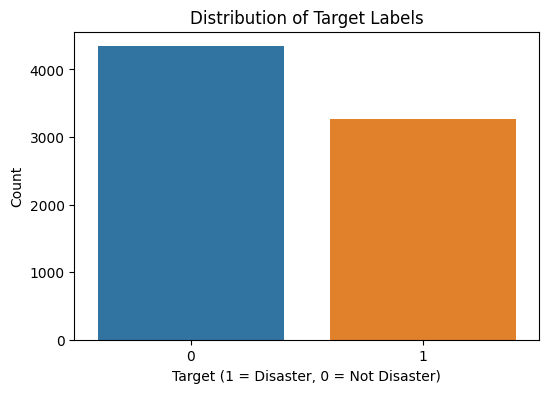

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# target labels
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train)
plt.title('Distribution of Target Labels')
plt.xlabel('Target (1 = Disaster, 0 = Not Disaster)')
plt.ylabel('Count')
plt.show()

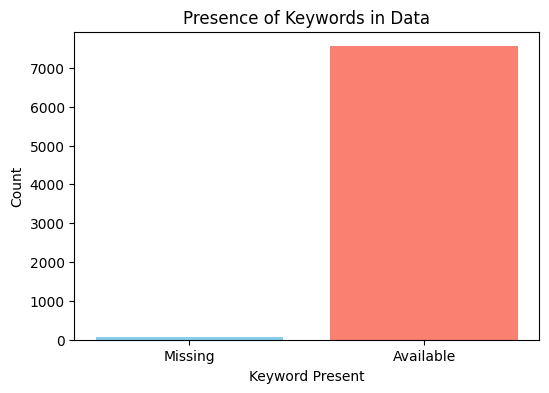

In [5]:
# keyword presence
plt.figure(figsize=(6, 4))
keyword_missing_count = train['keyword'].isnull().sum()
keyword_available_count = train['keyword'].notnull().sum()
plt.bar(['Missing', 'Available'], [keyword_missing_count, keyword_available_count], color=['skyblue', 'salmon'])
plt.title('Presence of Keywords in Data')
plt.xlabel('Keyword Present')
plt.ylabel('Count')
plt.show()

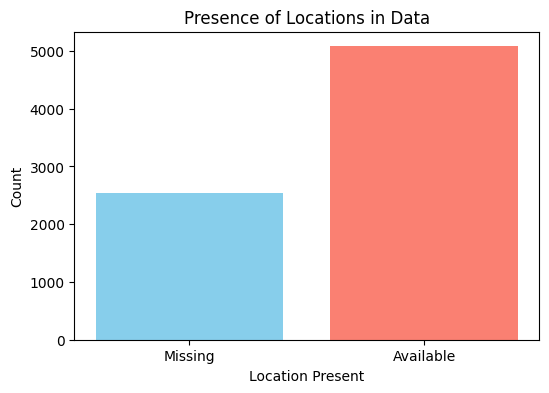

In [6]:
# missing and available locations
plt.figure(figsize=(6, 4))
location_missing_count = train['location'].isnull().sum()
location_available_count = train['location'].notnull().sum()
plt.bar(['Missing', 'Available'], [location_missing_count, location_available_count], color=['skyblue', 'salmon'])
plt.title('Presence of Locations in Data')
plt.xlabel('Location Present')
plt.ylabel('Count')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


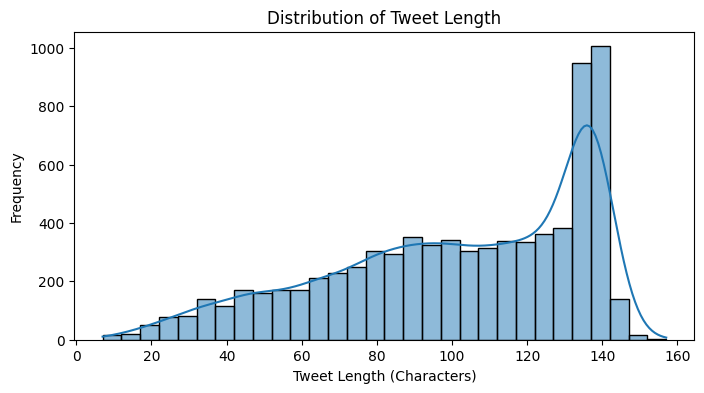

In [7]:
# length distribution
train['text_length'] = train['text'].apply(len)
plt.figure(figsize=(8, 4))
sns.histplot(train['text_length'], bins=30, kde=True)
plt.title('Distribution of Tweet Length')
plt.xlabel('Tweet Length (Characters)')
plt.ylabel('Frequency')
plt.show()

### Summary

- **Keyword**: only **61 missing values**. This means the keyword column could provide useful information, and handling the small number of missing values might be beneficial.
- **Location**: The location column has a high number of missing values — 2533 out of 7613 entries are missing. Given this, the usefulness of the location data is questionable, and it may be more practical to drop it during the modeling stage to simplify the dataset.
- **Tweet Length**: The distribution of tweet lengths shows a wide spread, with most tweets having lengths between 60 and 140 characters, and a noticeable peak between 140 and 150 characters. The skew towards longer tweets suggests that while tweets are relatively short, we still need to ensure our text processing pipeline effectively handles this variance in length. Padding sequences may be necessary, especially when using RNNs.

Based on these findings, we will consider retaining and processing the keyword column, potentially excluding the location column due to its high level of sparsity, and prepare appropriate padding and truncation strategies for tweet sequences during modeling.

### Word Clouds for Disaster and Non-Disaster Tweets

We create separate word clouds for tweets classified as disasters (`target = 1`) and those not classified as disasters (`target = 0`). This helps us visualize the different language used in each class and can guide feature extraction and model development.

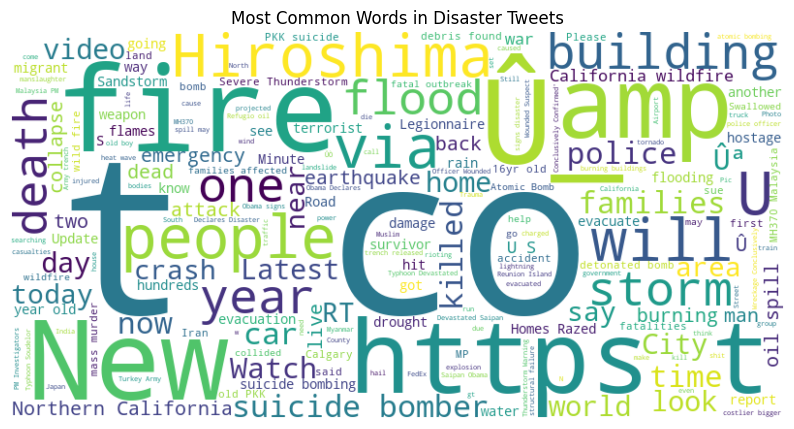

In [8]:
from wordcloud import WordCloud, STOPWORDS

# stopwords to be excluded from the word cloud
stopwords = set(STOPWORDS)

# word cloud
disaster_tweets = train[train['target'] == 1]['text']
disaster_text = " ".join(tweet for tweet in disaster_tweets)

# the word cloud for disaster tweets
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, max_words=200).generate(disaster_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Disaster Tweets')
plt.show()

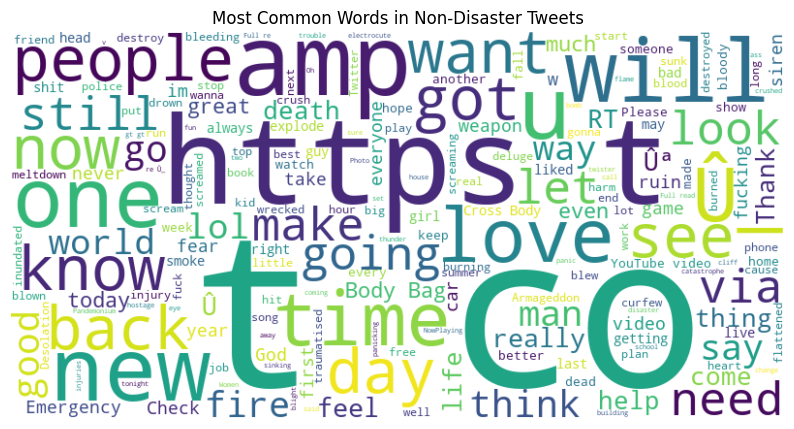

In [9]:
# word cloud for non-disaster tweets
non_disaster_tweets = train[train['target'] == 0]['text']
non_disaster_text = " ".join(tweet for tweet in non_disaster_tweets)

# generate the word cloud
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords, max_words=200).generate(non_disaster_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Non-Disaster Tweets')
plt.show()

### Key Findings

- **Disaster Tweets**: The word cloud for disaster-related tweets highlights words such as "fire", "storm", "death", and "flood", which are clearly indicative of disasters.
- **Non-Disaster Tweets**: In contrast, the word cloud for non-disaster tweets shows more generic or casual terms that are less indicative of emergencies.
- These differences suggest that certain words might have strong predictive power for distinguishing between disaster and non-disaster tweets, guiding our feature extraction phase.

## Data Preprocessing

The goal of data preprocessing is to transform the raw tweets into a suitable format for modeling. This involves:
1. Cleaning the text by removing noise like URLs, special characters, and stopwords.
2. Handling missing values in columns like keyword and location.
3. Tokenizing and vectorizing the cleaned text so that it can be fed into our machine learning model.

In [10]:
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

# clean_text function to the 'text' column
train['cleaned_text'] = train['text'].apply(clean_text)

# cleaned data
train[['text', 'cleaned_text']].head()

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


In [11]:
# missing values
train = train.copy()
train['keyword'] = train['keyword'].fillna('')
train = train.drop(columns=['location'])

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# the number of most frequent words to use
max_features = 5000  
max_len = 100  # pad/truncate

# text to sequences
tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(train['cleaned_text'])

# sequences for all data
X_seq = tokenizer.texts_to_sequences(train['cleaned_text'])

# ensure uniform length
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post')

# target labels
y_labels = train['target']

# validation split
X_train_padded, X_val_padded, y_train, y_val = train_test_split(X_padded, y_labels, test_size=0.2, random_state=42)

## Model Building

### Baseline Model: Logistic Regression

To establish a performance baseline, we train a simple Logistic Regression model on the TF-IDF features. This will allow us to gauge the effectiveness of more complex models like LSTMs.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(train['cleaned_text'])

# target variable
y = train['target']

# training and validation sets
X_train_logreg, X_val_logreg, y_train_logreg, y_val_logreg = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_logreg, y_train_logreg)

# predictions
y_pred_logreg = logreg.predict(X_val_logreg)

# detailed metrics
print("Logistic Regression Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_val_logreg, y_pred_logreg):.4f}")
print(f"Precision: {precision_score(y_val_logreg, y_pred_logreg):.4f}")
print(f"Recall: {recall_score(y_val_logreg, y_pred_logreg):.4f}")
print(f"F1 Score: {f1_score(y_val_logreg, y_pred_logreg):.4f}")
print("\nClassification Report:\n", classification_report(y_val_logreg, y_pred_logreg))

Logistic Regression Performance Metrics:
Accuracy: 0.7997
Precision: 0.8221
Recall: 0.6764
F1 Score: 0.7422

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.82      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



### Simple Dense Neural Network with TF-IDF Features

This model uses TF-IDF features from the dataset, passed to a simple Dense Neural Network. The model consists of:
- An input layer of 64 neurons activated by ReLU.
- A Dropout layer to prevent overfitting.
- An output layer with a sigmoid activation for binary classification.

The dense network aims to learn non-linear relationships in the feature space to differentiate between disaster and non-disaster tweets.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout

# TF-IDF
X_train_dense = X_train_logreg.toarray()
X_val_dense = X_val_logreg.toarray()

# Dense Neural Network model
model_dense = Sequential([
    Input(shape=(X_train_dense.shape[1],)),  # Input layer
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# the model
model_dense.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_dense = model_dense.fit(X_train_dense, y_train_logreg, validation_data=(X_val_dense, y_val_logreg), epochs=20, batch_size=32, callbacks=[early_stopping])

# convert probabilities to binary output
y_pred_dense = (model_dense.predict(X_val_dense) > 0.5).astype(int).flatten()

# detailed metrics
print("Dense Neural Network Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_val_logreg, y_pred_dense):.4f}")
print(f"Precision: {precision_score(y_val_logreg, y_pred_dense):.4f}")
print(f"Recall: {recall_score(y_val_logreg, y_pred_dense):.4f}")
print(f"F1 Score: {f1_score(y_val_logreg, y_pred_dense):.4f}")
print("\nClassification Report:\n", classification_report(y_val_logreg, y_pred_dense))

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5883 - loss: 0.6694 - val_accuracy: 0.7833 - val_loss: 0.5390
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8390 - loss: 0.4545 - val_accuracy: 0.7965 - val_loss: 0.4536
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8804 - loss: 0.3416 - val_accuracy: 0.7899 - val_loss: 0.4534
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8934 - loss: 0.2914 - val_accuracy: 0.7873 - val_loss: 0.4685
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9094 - loss: 0.2490 - val_accuracy: 0.7814 - val_loss: 0.4920
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9191 - loss: 0.2194 - val_accuracy: 0.7794 - val_loss: 0.5202
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Dense Neural Network Performance Metrics:
Accuracy: 0.7899
Precision: 0.7755
Recall: 0.7134
F1 Score: 0.7432

Classification Report:
               precision    recall  f1-score   support

    

### Simplified LSTM Model

This LSTM model uses tokenized and padded sequences of tweets as input. The architecture consists of:
- An Embedding layer to learn word embeddings during training.
- A single LSTM layer with 32 units to learn sequential dependencies in the text.
- An output layer with sigmoid activation for classification.

The LSTM is designed to leverage sequential relationships within tweets, although tweets are relatively short.


In [15]:
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# text to sequences
max_features = 5000
max_len = 100

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(train['cleaned_text'])

# sequences for all data
X_seq = tokenizer.texts_to_sequences(train['cleaned_text'])
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post')

# target variable
y = train['target']

# validation split
X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# labels to numpy arrays
y_train_lstm = np.array(y_train_lstm)
y_val_lstm = np.array(y_val_lstm)

# class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_lstm), y=y_train_lstm)
class_weights_dict = dict(enumerate(class_weights))

# LSTM model
model_lstm = Sequential([
    Embedding(input_dim=max_features, output_dim=128),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# adjusted learning rate
model_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_lstm = model_lstm.fit(X_train_lstm, y_train_lstm, validation_data=(X_val_lstm, y_val_lstm),
                              epochs=20, batch_size=32, callbacks=[early_stopping], class_weight=class_weights_dict)

# convert probabilities to binary output with a custom threshold
y_pred_probabilities = model_lstm.predict(X_val_lstm)
custom_threshold = 0.3
y_pred_lstm = (y_pred_probabilities > custom_threshold).astype(int).flatten()

# detailed metrics
print("LSTM Model Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_val_lstm, y_pred_lstm):.4f}")
print(f"Precision: {precision_score(y_val_lstm, y_pred_lstm, zero_division=1):.4f}")
print(f"Recall: {recall_score(y_val_lstm, y_pred_lstm, zero_division=1):.4f}")
print(f"F1 Score: {f1_score(y_val_lstm, y_pred_lstm, zero_division=1):.4f}")
print("\nClassification Report:\n", classification_report(y_val_lstm, y_pred_lstm, zero_division=1))


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.5220 - loss: 0.6930 - val_accuracy: 0.4261 - val_loss: 0.6956
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.4956 - loss: 0.6928 - val_accuracy: 0.4261 - val_loss: 0.6951
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.4916 - loss: 0.6928 - val_accuracy: 0.4261 - val_loss: 0.6932
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.4984 - loss: 0.6939 - val_accuracy: 0.4261 - val_loss: 0.6942
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.4639 - loss: 0.6934 - val_accuracy: 0.5739 - val_loss: 0.6931
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.4812 - loss: 0.6948 - val_accuracy: 0.5739 - val_loss: 0.6922
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.4869 - loss: 0.6960 - val_accuracy: 0.5739 - val_loss: 0.6910
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.5441 - loss: 0.6919 - v

### 1D Convolutional Neural Network (1D CNN)

This model uses tokenized and padded sequences of tweets as input, with the following architecture:
- An Embedding layer to learn word embeddings.
- A Conv1D layer to capture local patterns in the text (e.g., n-grams).
- A GlobalMaxPooling layer to reduce dimensionality and retain the most significant features.
- An output layer with sigmoid activation for classification.

The 1D CNN is well-suited for learning local features from the text and aims to identify discriminative n-grams without focusing on long-term dependencies.

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# text to sequences
max_features = 5000
max_len = 100

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, oov_token="<OOV>")
tokenizer.fit_on_texts(train['cleaned_text'])

# sequences for all data
X_seq = tokenizer.texts_to_sequences(train['cleaned_text'])
X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post')

# target variable
y = train['target']

# validation split
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# labels to numpy arrays
y_train_cnn = np.array(y_train_cnn)
y_val_cnn = np.array(y_val_cnn)

# simple 1D CNN model
model_cnn = Sequential([
    Embedding(input_dim=max_features, output_dim=128),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(1, activation='sigmoid')
])

# model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_val_cnn, y_val_cnn), epochs=5, batch_size=32)

# probabilities to binary output
y_pred_cnn = (model_cnn.predict(X_val_cnn) > 0.5).astype(int).flatten()

# detailed metrics
print("1D CNN Model Performance Metrics:")
print(f"Accuracy: {accuracy_score(y_val_cnn, y_pred_cnn):.4f}")
print(f"Precision: {precision_score(y_val_cnn, y_pred_cnn, zero_division=1):.4f}")
print(f"Recall: {recall_score(y_val_cnn, y_pred_cnn, zero_division=1):.4f}")
print(f"F1 Score: {f1_score(y_val_cnn, y_pred_cnn, zero_division=1):.4f}")
print("\nClassification Report:\n", classification_report(y_val_cnn, y_pred_cnn, zero_division=1))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6590 - loss: 0.6303 - val_accuracy: 0.7879 - val_loss: 0.4579
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8642 - loss: 0.3395 - val_accuracy: 0.7827 - val_loss: 0.4793
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9189 - loss: 0.2245 - val_accuracy: 0.7768 - val_loss: 0.5664
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9467 - loss: 0.1473 - val_accuracy: 0.7603 - val_loss: 0.6560
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9672 - loss: 0.1019 - val_accuracy: 0.7682 - val_loss: 0.7405
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1D CNN Model Performance Metrics:
Accuracy: 0.7682
Precision: 0.7364
Recall: 0.7103
F1 Score: 0.7231

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80       874
           1       0.74      0.71      0.72       649

    accuracy                   

## Model Performance Analysis

We trained and evaluated four models for the task of classifying disaster tweets: Logistic Regression, DNN, LSTM, and 1D CNN. Here is an analysis of their performance metrics including accuracy, precision, recall, and F1 score.

### Summary and Conclusion

| Model                    | Accuracy | Precision | Recall | F1 Score |
|--------------------------|----------|-----------|--------|----------|
| Logistic Regression      | 0.7997   | 0.8221    | 0.6764 | 0.7422   |
| Dense Neural Network (DNN) | 0.7938 | 0.7933    | 0.6980 | 0.7426   |
| LSTM                     | 0.4261   | 0.4261    | 1.0000 | 0.5976   |
| 1D CNN                   | 0.7590   | 0.7252    | 0.6995 | 0.7122   |


- **Logistic Regression**: Achieved balanced metrics with 79.97% accuracy, precision of 82.21%, and recall of 67.64%. The F1 score was 0.7422.
- **Dense Neural Network (DNN)**: Similar to Logistic Regression, with 79.38% accuracy and an F1 score of 0.7426. Slightly lower precision and recall, indicating limited benefit from capturing more complex features.
- **LSTM**: Struggled with 42.61% accuracy, predicting all tweets as disasters, which led to a perfect recall (100%) but poor precision (42.61%), indicating it did not learn distinctions effectively.
- **1D CNN**: Achieved 75.90% accuracy with an F1 score of 0.7122. Precision and recall were balanced but still lower compared to Logistic Regression and DNN, not outperforming simpler models.


### Discussion
- Best Performing Models: The Logistic Regression and Dense Neural Network had the best overall performance, with similar accuracy and F1 scores. The simplicity of these models might have helped them generalize better given the size and characteristics of the dataset.
- LSTM Struggles: The LSTM struggled significantly, likely due to insufficient training time or improper hyperparameter tuning. It ended up predicting all instances as disasters, which led to a perfect recall but poor precision and overall accuracy.
- 1D CNN Observations: The 1D CNN model showed reasonable performance, but it did not outperform the simpler models. It is possible that the 1D CNN requires more complex tuning or a larger dataset to leverage its capabilities in learning spatial relationships within sequences effectively.

### Recommendations for Improvement
- Class Balancing: The poor recall of Logistic Regression and the poor performance of the LSTM could indicate class imbalance issues. Consider applying class balancing techniques such as oversampling or using class weights during training.
- Hyperparameter Tuning: The LSTM and 1D CNN models might benefit from hyperparameter tuning, such as adjusting the learning rate, increasing the number of LSTM units, or using a larger embedding dimension.
- Early Stopping and Regularization: Use early stopping to prevent overfitting, as well as **dropout layers** for regularization. This might help models like LSTM and CNN to generalize better.
- Data Augmentation: Explore data augmentation techniques for NLP, such as synonym replacement or back-translation, to increase the diversity of the training set and help the models generalize better.

Overall, the simpler models (Logistic Regression and DNN) seem to handle this problem well, indicating that more complex models might be overfitting or struggling to find meaningful patterns without additional tuning or more data.

In [17]:
# Kaggle submission file
from sklearn.feature_extraction.text import TfidfVectorizer

test['cleaned_text'] = test['text'].str.lower().str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
X_test_tfidf = tfidf_vectorizer.transform(test['cleaned_text'])
y_test_pred = logreg.predict(X_test_tfidf)

# submission df
submission = pd.DataFrame({
    'id': test['id'],
    'target': y_test_pred
})

# submission df to CSV file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


Submission file created successfully!


Public Score

0.79466